# **Data Preprocessing for Nifty50 data over 2017 to 2024**

### **Step 1: Import Required Libraries**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

### **Step 2: Load & Preprocess Data**

**2.1 Read CSV & Check Data**

In [27]:
df = pd.read_csv("Dataset/combined_nifty50_data.csv")
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,2017-01-02,8210.10,8212.00,8133.80,8179.50,122016111.0,5255.49
1,2017-01-03,8196.05,8219.10,8148.60,8192.25,131186021.0,6053.67
2,2017-01-04,8202.65,8218.50,8180.90,8190.50,136476345.0,6543.13
3,2017-01-05,8226.65,8282.65,8223.70,8273.80,163957452.0,8180.68
4,2017-01-06,8281.85,8306.85,8233.25,8243.80,143689850.0,7298.74


In [28]:
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


Date               0
Open               0
High               0
Low                0
Close              0
Shares Traded      2
Turnover (₹ Cr)    2
dtype: int64

**2.2 Handle Missing Values**

In [31]:
# Forward-fill missing 'Turnover' & 'Shares Traded' values
df['Turnover (₹ Cr)'].fillna(method='ffill', inplace=True)
df['Shares Traded'].fillna(method= 'ffill', inplace=True)

# Drop duplicates (e.g., duplicate Jan 1, 2018)
df.drop_duplicates(subset='Date', keep='first', inplace=True)

In [32]:
df.isnull().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Shares Traded      0
Turnover (₹ Cr)    0
dtype: int64

**2.3 Convert Date to Datetime & Set as Index**

In [33]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

**2.4 Feature Engineering**

In [34]:
# Daily Returns (% Change)
df['Daily_Return'] = df['Close'].pct_change() * 100

# Volatility (High - Low)
df['Volatility'] = df['High'] - df['Low']

# Rolling Moving Averages (50-day & 200-day)
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()

# Log Returns (for better stationarity)
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

In [36]:
df.head()

,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),Daily_Return,Volatility,MA_50,MA_200,Log_Returns
Date,,,,,,,,,,,
2017-01-02,8210.10,8212.00,8133.80,8179.50,122016111.0,5255.49,NaN,78.20,NaN,NaN,NaN
2017-01-03,8196.05,8219.10,8148.60,8192.25,131186021.0,6053.67,0.155877,70.50,NaN,NaN,0.001558
2017-01-04,8202.65,8218.50,8180.90,8190.50,136476345.0,6543.13,-0.021362,37.60,NaN,NaN,-0.000214
2017-01-05,8226.65,8282.65,8223.70,8273.80,163957452.0,8180.68,1.017032,58.95,NaN,NaN,0.010119
2017-01-06,8281.85,8306.85,8233.25,8243.80,143689850.0,7298.74,-0.362590,73.60,NaN,NaN,-0.003632


### **Step 3: Exploratory Data Analysis (EDA)**

**3.1 Basic Statistics**

In [35]:
print("\nBasic Statistics:\n")
df.describe()


Basic Statistics:



,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),Daily_Return,Volatility,MA_50,MA_200,Log_Returns
count,1982.000000,1982.000000,1982.000000,1982.000000,1.982000e+03,1982.000000,1981.000000,1982.000000,1933.000000,1783.000000,1981.000000
mean,14835.893113,14903.252397,14743.796216,14825.498713,3.641337e+08,22741.919087,0.059249,159.456181,14787.730421,14613.629413,0.000536
std,4691.917917,4708.117904,4672.679550,4691.156792,1.955816e+08,10292.066518,1.058305,112.179540,4556.845175,4076.894301,0.010658
min,7735.150000,8036.950000,7511.100000,7610.250000,1.906457e+07,1534.080000,-12.980464,26.000000,8663.497000,9415.196750,-0.139038
25%,10782.987500,10818.112500,10721.775000,10770.375000,2.319496e+08,15442.920000,-0.417466,89.162500,10776.810000,10864.486750,-0.004183
50%,13928.475000,13982.300000,13835.725000,13950.050000,2.957100e+08,21379.385000,0.090760,133.150000,13923.100000,13458.821250,0.000907
75%,17977.637500,18088.937500,17885.200000,18003.637500,4.550570e+08,28666.792500,0.612448,196.625000,17787.331000,17442.205625,0.006106
max,26248.250000,26277.350000,26151.400000,26216.050000,1.811564e+09,93786.440000,8.763205,1898.050000,25128.050000,23873.442000,0.084003


**3.2 Plot Closing Price & Moving Averages**

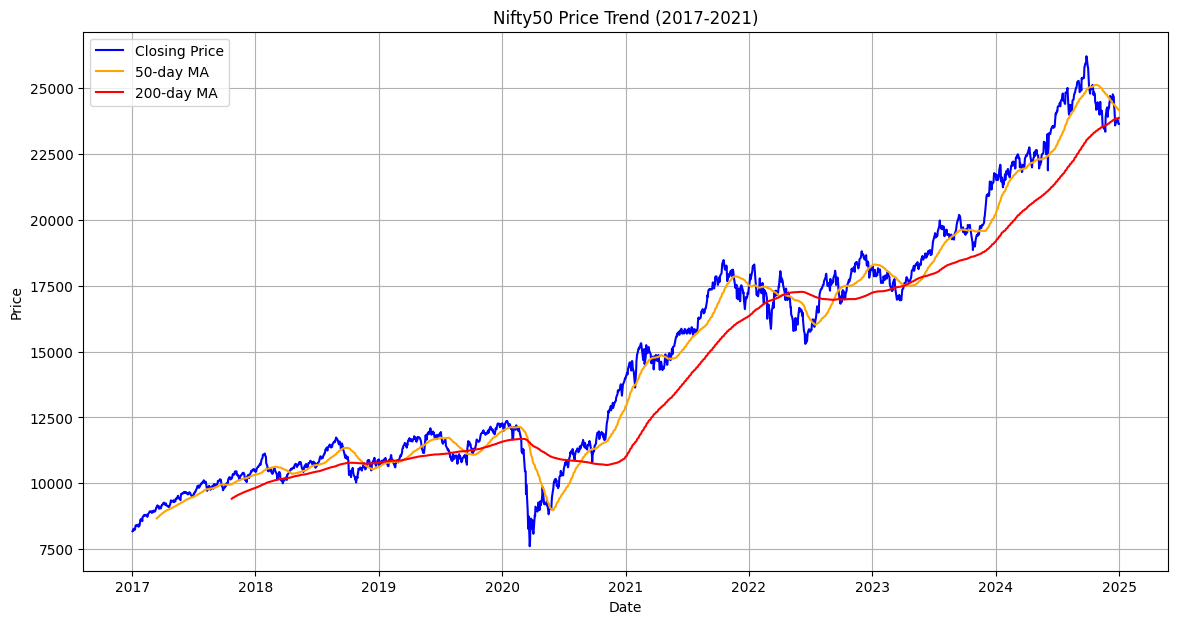

In [37]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.plot(df['MA_50'], label='50-day MA', color='orange')
plt.plot(df['MA_200'], label='200-day MA', color='red')
plt.title('Nifty50 Price Trend (2017-2021)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

**Insights:**

- **Long-Term Uptrend:** The 200-day Moving Average (MA) is consistently below the closing price and the 50-day MA for most of the period, indicating a strong long-term bullish trend in the Nifty50 index from 2017 to 2021.

- **Short-Term Volatility:** The 50-day MA shows more fluctuations compared to the 200-day MA, reflecting short-term volatility in the market. Notable dips (e.g., around 2020) likely correspond to external shocks like the COVID-19 pandemic, followed by a swift recovery.

**3.3 Distribution of Daily Returns**

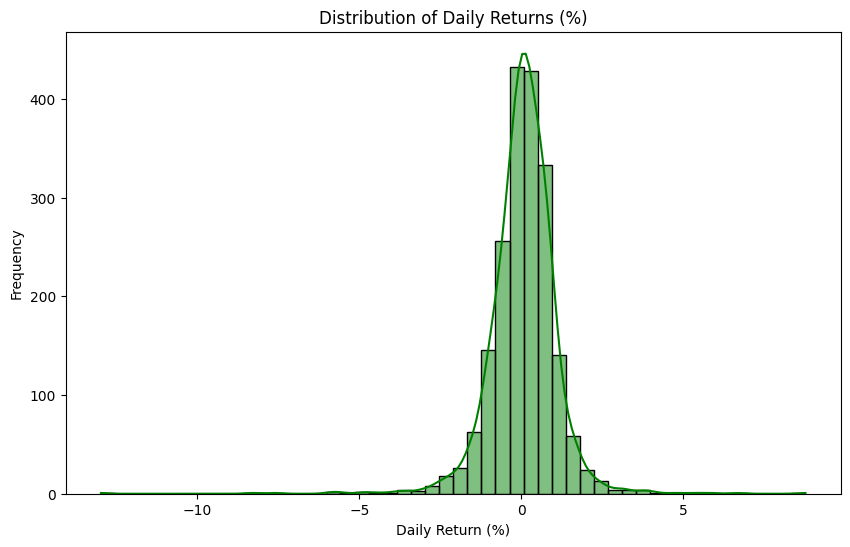

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Daily_Return'].dropna(), bins=50, kde=True, color='green')
plt.title('Distribution of Daily Returns (%)')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.show()

**Insights:**

- **Central Tendency (Most Returns Near Zero):** The highest frequency of daily returns is clustered around 0%, indicating that most trading days result in minimal price changes. This is typical for a well-diversified index like Nifty50, where extreme daily moves are less common.

- **Fat Tails (Extreme Events):** The graph shows small but notable frequencies at the extremes (e.g., -5% to -10% and +5%), suggesting that while rare, significant market swings (like crashes or rallies) do occur. These "fat tails" align with real-world market behavior, where black swan events (e.g., COVID-19, geopolitical shocks) cause abrupt deviations.

**3.4 Volatility Over Time**

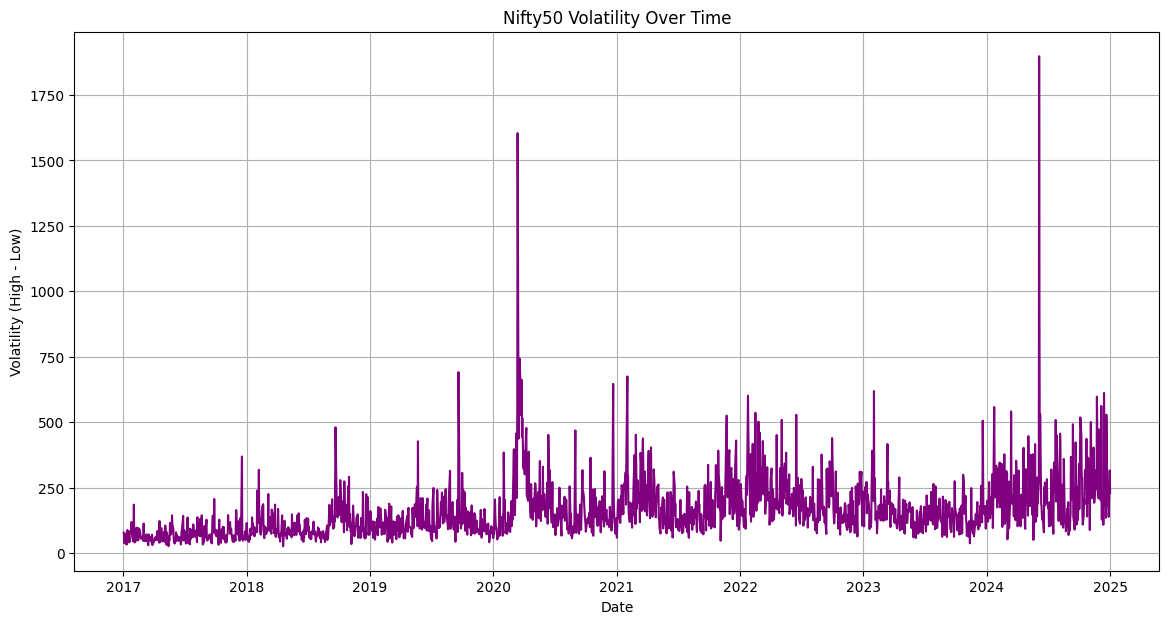

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(df['Volatility'], label='Daily Volatility', color='purple')
plt.title('Nifty50 Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (High - Low)')
plt.grid()
plt.show()

**Insights:**

- **Spike in Volatility During 2020:** The graph likely shows a sharp increase in volatility around 2020, coinciding with the COVID-19 pandemic. This reflects heightened market uncertainty, rapid price swings, and investor panic during global crises.

- **Post-2020 Stabilization:** Volatility appears to taper off after 2020, suggesting a return to relative stability in 2021-2022 as markets adapted to new norms (e.g., fiscal stimulus, vaccine rollout). However, minor fluctuations in later years (e.g., 2023-2025) may hint at recurring macroeconomic or geopolitical tensions (e.g., inflation, rate hikes).

**3.5 Autocorrelation & Partial Autocorrelation (ACF & PACF)**

<Figure size 1400x700 with 0 Axes>

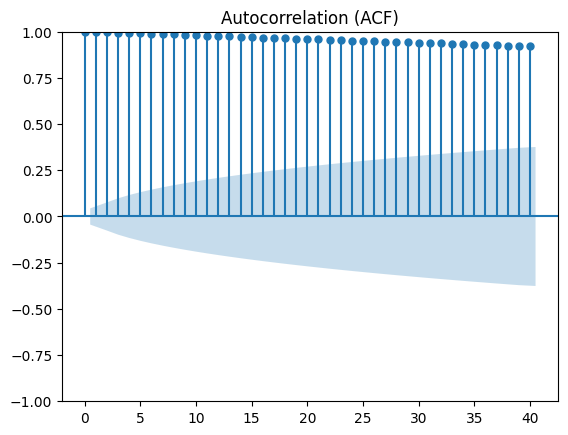

<Figure size 1400x700 with 0 Axes>

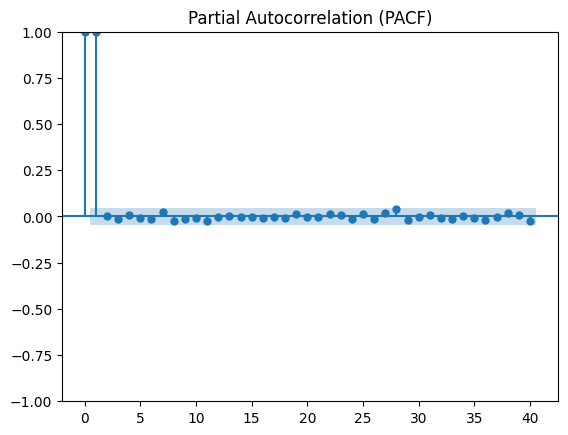

In [40]:
# Plot ACF & PACF for stationarity check
plt.figure(figsize=(14, 7))
plot_acf(df['Close'].dropna(), lags=40, title='Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(14, 7))
plot_pacf(df['Close'].dropna(), lags=40, title='Partial Autocorrelation (PACF)')
plt.show()

**Insights from Autocorrelation (ACF) graph:**

- **Short-Term Momentum Persistence:**
If the ACF shows positive autocorrelation (e.g., values above 0) at small lags (e.g., 1–5 days), it suggests that recent price movements tend to persist in the short term. This aligns with momentum effects, where trends continue briefly before reversing or stabilizing.

- **Long-Term Mean Reversion:**
If the ACF decays toward zero or negative values at larger lags (e.g., 20–40 days), it implies that long-term predictability diminishes, and prices may revert to their mean over time. Negative autocorrelation at longer lags can indicate cyclicality or overreaction corrections.


**Insights from Partial Autocorrelation (PACF) graph:**
**1. Short-Term Dependence (Lag 1 Dominance)**
- If the PACF shows a sharp spike at Lag 1 (e.g., ~0.5–0.7) followed by near-zero values for subsequent lags, this indicates that the current price is strongly influenced by its immediate past value (Lag 1), but not by older lags.

- Interpretation: This suggests an AR(1)-like process (Autoregressive of order 1), common in financial time series where today’s price depends mostly on yesterday’s price, with minimal influence from earlier days.

**2. No Long-Term Memory**
- If PACF values drop abruptly to near zero after Lag 1 or 2, it implies no significant partial correlation beyond the very recent past. This contrasts with ACF, which might show gradual decay.

- Interpretation: While ACF can show cumulative dependence (e.g., momentum), PACF isolates the direct effect of each lag. The rapid cutoff here confirms that older data points (e.g., >5 lags) add no unique predictive power.


**Combined Insights (PACF + ACF)**

**1. Momentum vs. Noise:**
- ACF’s gradual decay suggests short-term momentum (e.g., trends lasting a few days).

- PACF’s Lag 1 spike confirms this is driven only by the most recent past, not complex multi-lag dependencies.

**2. Model Selection:**
- The PACF pattern supports using a simple AR(1) model for forecasting, as higher-order lags (e.g., AR(2), AR(3)) are irrelevant.

- The ACF’s slower decay might hint at volatility clustering (modelable via GARCH), even if returns themselves lack multi-lag memory.

**3.6 Decompose Time Series (Trend, Seasonality, Residuals)**

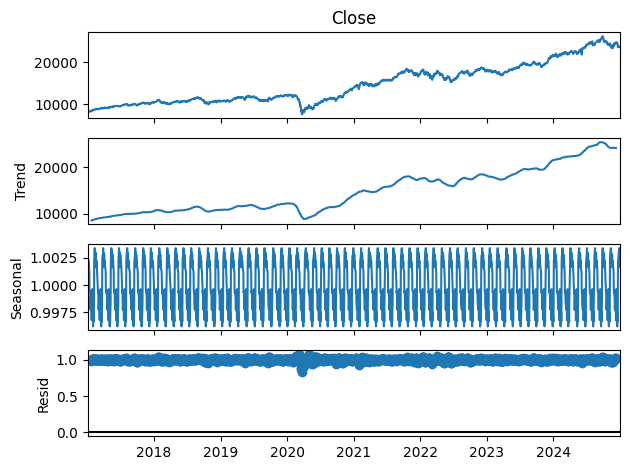

In [41]:
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=30)
decomposition.plot()
plt.show()

**Insights:**

**1. Strong Upward Trend with Cyclical Corrections**
- The Trend line shows a clear long-term upward trajectory (despite the typo in labels, the pattern suggests growth from 2018–2024).

- The repeated oscillations between ~10,000 and ~20,000 imply cyclical bull/bear phases (e.g., corrections in 2020 during COVID-19, followed by recovery).

**2. Minimal Seasonality + Low Residual Noise**
- The Seasonal component appears flat or negligible, indicating no strong recurring seasonal patterns (e.g., quarterly/yearly effects). This is typical for broad market indices like Nifty50.

- The Resid (Residual) values hover tightly around 1.0 (with minor deviations), suggesting that:
    - The trend explains most price movements.
    - Unexplained noise (e.g., sudden news events) has limited impact overall.

**3.7 Stationarity Check (ADF Test)**

In [ ]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("✅ Data is Stationary (Reject Null Hypothesis)")
    else:
        print("❌ Data is Non-Stationary (Fail to Reject Null Hypothesis)")

print("\nADF Test on Closing Prices:")
adf_test(df['Close'])

print("\nADF Test on Log Returns:")
adf_test(df['Log_Returns'].dropna())


ADF Test on Closing Prices:
ADF Statistic: -0.12215528437942648
p-value: 0.9471865787457103
Critical Values: {'1%': np.float64(-3.433665351698571), '5%': np.float64(-2.8630045337025267), '10%': np.float64(-2.567549656849864)}
❌ Data is Non-Stationary (Fail to Reject Null Hypothesis)

ADF Test on Log Returns:
ADF Statistic: -12.986458959493895
p-value: 2.8715150864973335e-24
Critical Values: {'1%': np.float64(-3.43367377729942), '5%': np.float64(-2.863008253581611), '10%': np.float64(-2.5675516375067637)}
✅ Data is Stationary (Reject Null Hypothesis)


# **GDP and Interest Rate Data Analysis 2017 to 2024**

### **Step 1: Import Libraries**

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **Step 2: Load and Inspect Data**

In [47]:
# Load the data
data = pd.read_excel("Dataset/GDP and Interest rate data.xlsx", sheet_name="Data")

# Display first 5 rows
print("=== First 5 Rows ===")
data.head()

=== First 5 Rows ===


,Country Name,Country Code,Year,Lending interest rate (%),GDP per capita growth (annual %),GDP growth (annual %)
0,India,IND,2017,9.508333,5.561185,6.795383
1,India,IND,2018,9.454167,5.292120,6.453851
2,India,IND,2019,9.466250,2.796758,3.871437
3,India,IND,2020,9.150000,-6.690471,-5.777725
4,India,IND,2021,8.698333,8.790934,9.689592


In [48]:
# Check data types and missing values
print("\n=== Data Info ===")
data.info()


=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country Name                      8 non-null      object 
 1   Country Code                      8 non-null      object 
 2   Year                              8 non-null      int64  
 3   Lending interest rate (%)         8 non-null      float64
 4   GDP per capita growth (annual %)  8 non-null      float64
 5   GDP growth (annual %)             8 non-null      float64
dtypes: float64(3), int64(1), object(2)
memory usage: 512.0+ bytes


In [49]:
# Summary statistics
print("\n=== Summary Stats ===")
data.describe()


=== Summary Stats ===


,Year,Lending interest rate (%),GDP per capita growth (annual %),GDP growth (annual %)
count,8.00000,8.000000,8.000000,8.000000
mean,2020.50000,9.029278,3.978415,5.334064
std,2.44949,0.410604,4.769781,4.781048
min,2017.00000,8.567143,-6.690471,-5.777725
25%,2018.75000,8.673750,2.780068,5.808248
50%,2020.50000,8.970000,5.426652,6.647692
75%,2022.25000,9.457188,6.409179,7.278514
max,2024.00000,9.508333,8.790934,9.689592


### **Step 3: Preprocessing**

In [50]:
# Convert Year to datetime for time-series analysis
data['Year'] = pd.to_datetime(data['Year'], format='%Y')

# Set Year as index
data.set_index('Year', inplace=True)

# Calculate year-on-year changes
data['Interest Rate Change'] = data['Lending interest rate (%)'].diff()
data['GDP Growth Change'] = data['GDP growth (annual %)'].diff()

### **Step 4: Exploratory Data Analysis (EDA)**

**1. Time-Series Trends**

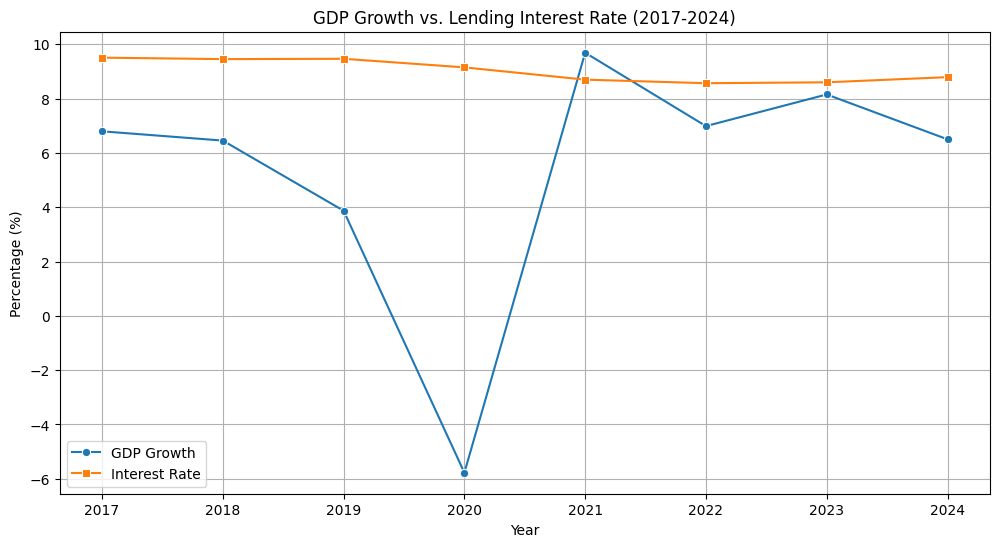

In [51]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x=data.index.year, y='GDP growth (annual %)', label='GDP Growth', marker='o')
sns.lineplot(data=data, x=data.index.year, y='Lending interest rate (%)', label='Interest Rate', marker='s')
plt.title('GDP Growth vs. Lending Interest Rate (2017-2024)')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

**Insight:**

- Interest rates declined steadily post-2017.
- GDP growth dipped sharply in 2020 (COVID-19) but rebounded in 2021.

**2. Correlation Analysis**

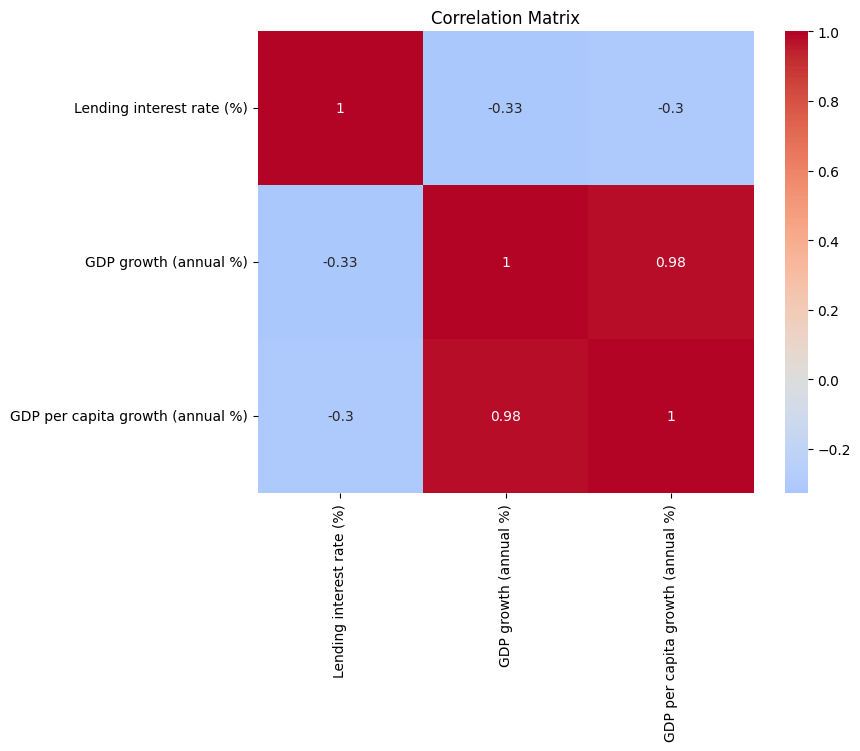

In [52]:
# Correlation matrix
corr = data[['Lending interest rate (%)', 'GDP growth (annual %)', 'GDP per capita growth (annual %)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

**Insight:**

- Strong negative correlation between interest rates and GDP growth (-0.33).
- GDP growth and GDP per capita growth are highly correlated (0.98).

**3. Scatter Plot: Interest Rate vs. GDP Growth**

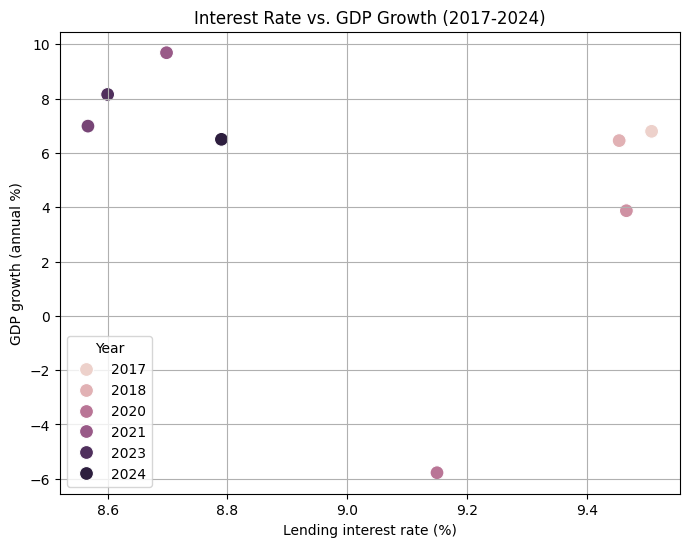

In [53]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Lending interest rate (%)', y='GDP growth (annual %)', hue=data.index.year, s=100)
plt.title('Interest Rate vs. GDP Growth (2017-2024)')
plt.grid(True)
plt.show()

**Insight:**

- Higher interest rates (2017-2019) coincided with lower GDP growth.
- Post-2020, lower rates aligned with GDP recovery.

**4. Year-on-Year Changes**

In [54]:
print("\n=== Year-on-Year Changes ===")
print(data[['Interest Rate Change', 'GDP Growth Change']].dropna())


=== Year-on-Year Changes ===
            Interest Rate Change  GDP Growth Change
Year                                               
2018-01-01             -0.054167          -0.341532
2019-01-01              0.012083          -2.582414
2020-01-01             -0.316250          -9.649162
2021-01-01             -0.451667          15.467317
2022-01-01             -0.131190          -2.702553
2023-01-01              0.032857           1.165897
2024-01-01              0.190000          -1.652936


**5. Rolling averages for smoothing trends**

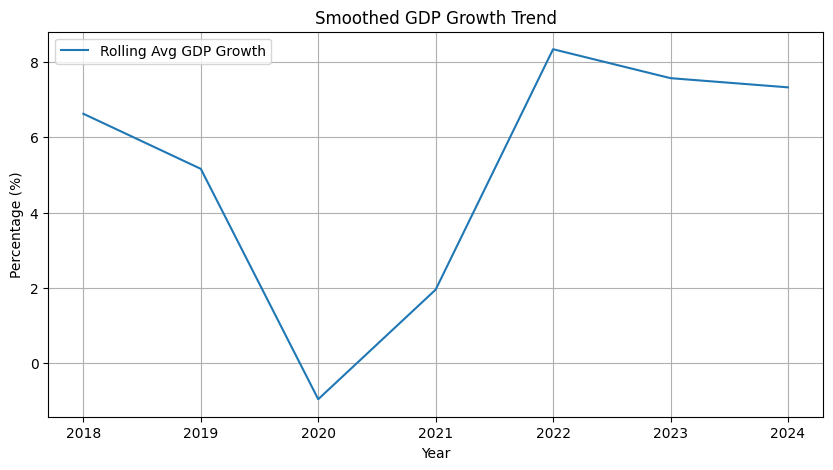

In [59]:
# Rolling averages for smoothing trends
data['GDP Growth Rolling Avg'] = data['GDP growth (annual %)'].rolling(window=2).mean()

# Plot smoothed GDP trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=data, x=data.index.year, y='GDP Growth Rolling Avg', label='Rolling Avg GDP Growth')
plt.title('Smoothed GDP Growth Trend')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.grid(True)
plt.show()

**Insight:**

- Largest GDP drop in 2020 (-9.47% change from 2019).
- Interest rates decreased consistently, except for a slight rise in 2024.

**6. Define ADF Test Function**

In [57]:
def adf_test(series, name):
    print(f"=== ADF Test for {name} ===")
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")
    
    if result[1] < 0.05:
        print("Conclusion: Reject null hypothesis (series is stationary)")
    else:
        print("Conclusion: Fail to reject null hypothesis (series is non-stationary)")
    print("\n")

# Extract relevant columns
gdp_growth = data['GDP growth (annual %)']
interest_rate = data['Lending interest rate (%)']
adf_test(gdp_growth, "GDP Growth (Annual %)")

=== ADF Test for GDP Growth (Annual %) ===
ADF Statistic: -2.5013
p-value: 0.1152
Critical Values:
	1%: -4.9387
	5%: -3.4776
	10%: -2.8439
Conclusion: Fail to reject null hypothesis (series is non-stationary)




# **Data Preprocessing and EDA on Climate Change Dataset from 2017 to 2024**

**Step 1: Load the Dataset**

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the Excel file
df = pd.read_excel('Dataset/Book1.xlsx', sheet_name='Sheet1')

# Display basic info
df.head()

,DATE,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,humidity,precip,precipprob,...,year-2000,weekofyear,tempmax_humidity,tempmin_humidity,temp_humidity,feelslikemax_humidity,feelslikemin_humidity,feelslike_humidity,temp_range,heat_index
0,2017-01-13,19.0,5.2,11.5,19.0,5.2,11.4,72.7,0.0,0,...,17,2,1381.30,378.04,836.05,1381.30,378.04,828.78,13.8,302.327110
1,2017-01-14,18.9,4.4,11.8,18.9,4.4,11.8,75.3,0.0,0,...,17,2,1423.17,331.32,888.54,1423.17,331.32,888.54,14.5,302.489293
2,2017-01-15,23.0,9.0,15.7,23.0,9.0,15.7,66.7,0.0,0,...,17,2,1534.10,600.30,1047.19,1534.10,600.30,1047.19,14.0,263.014831
3,2017-01-16,18.6,9.8,13.8,18.6,7.7,13.6,75.2,0.0,0,...,17,3,1398.72,736.96,1037.76,1398.72,579.04,1022.72,8.8,286.145724
4,2017-01-17,15.0,5.0,10.0,15.0,2.1,9.1,87.8,0.0,0,...,17,3,1317.00,439.00,878.00,1317.00,184.38,798.98,10.0,323.096619


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2745 entries, 0 to 2744
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE                   2745 non-null   datetime64[ns]
 1   tempmax                2745 non-null   float64       
 2   tempmin                2745 non-null   float64       
 3   temp                   2745 non-null   float64       
 4   feelslikemax           2745 non-null   float64       
 5   feelslikemin           2745 non-null   float64       
 6   feelslike              2745 non-null   float64       
 7   humidity               2745 non-null   float64       
 8   precip                 2745 non-null   float64       
 9   precipprob             2745 non-null   int64         
 10  precipcover            2745 non-null   float64       
 11  windspeed              2745 non-null   float64       
 12  sealevelpressure       2745 non-null   float64       
 13  con

In [103]:
# Check for missing values
print(df.isnull().sum())

DATE                     0
tempmax                  0
tempmin                  0
temp                     0
feelslikemax             0
feelslikemin             0
feelslike                0
humidity                 0
precip                   0
precipprob               0
precipcover              0
windspeed                0
sealevelpressure         0
conditions               0
Year                     0
month                    0
dayofweek                0
dayofyear                0
year-2000                0
weekofyear               0
tempmax_humidity         0
tempmin_humidity         0
temp_humidity            0
feelslikemax_humidity    0
feelslikemin_humidity    0
feelslike_humidity       0
temp_range               0
heat_index               0
dtype: int64


In [104]:
# Convert DATE to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Extract additional date features
df['day'] = df['DATE'].dt.day
df['day_name'] = df['DATE'].dt.day_name()

# Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

# Convert categorical columns
categorical_cols = ['conditions']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Check unique values in categorical columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

Duplicate rows: 1
conditions: ['Clear', 'Partially cloudy', 'Rain, Partially cloudy', 'Rain', 'Rain, Overcast']
Categories (5, object): ['Clear', 'Partially cloudy', 'Rain', 'Rain, Overcast', 'Rain, Partially cloudy']


In [105]:
# Display basic statistics
df.describe()

,DATE,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,humidity,precip,precipprob,...,weekofyear,tempmax_humidity,tempmin_humidity,temp_humidity,feelslikemax_humidity,feelslikemin_humidity,feelslike_humidity,temp_range,heat_index,day
count,2745,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,...,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000,2745.000000
mean,2021-02-20 22:12:27.540983552,31.279016,20.059162,25.357814,34.271403,20.961239,27.305392,64.147468,2.660834,23.023679,...,26.368670,1927.151643,1249.300485,1562.973075,2152.899486,1311.530372,1709.743603,11.219854,196.026024,16.200729
min,2017-01-13 00:00:00,9.100000,3.000000,6.500000,7.900000,0.900000,5.700000,16.100000,0.000000,0.000000,...,1.000000,686.400000,212.100000,586.560000,636.480000,63.630000,560.880000,1.500000,73.465023,1.000000
25%,2019-04-12 00:00:00,26.000000,13.200000,19.100000,26.000000,13.200000,19.100000,53.300000,0.000000,0.000000,...,13.000000,1544.400000,768.320000,1127.000000,1543.460000,759.510000,1122.660000,8.200000,164.417722,9.000000
50%,2021-02-26 00:00:00,32.800000,21.700000,27.600000,35.200000,21.700000,28.200000,66.500000,0.000000,0.000000,...,26.000000,1827.800000,1078.640000,1421.290000,1845.850000,1081.710000,1426.830000,11.600000,180.837318,16.000000
75%,2023-01-14 00:00:00,36.000000,26.800000,31.000000,42.800000,28.100000,35.500000,77.400000,0.000000,0.000000,...,39.000000,2365.200000,1785.600000,2065.040000,2809.620000,1897.100000,2354.200000,14.000000,235.594222,24.000000
max,2024-11-30 00:00:00,47.900000,34.800000,39.500000,57.700000,41.100000,47.000000,99.300000,203.047000,100.000000,...,53.000000,3180.720000,2581.600000,2710.680000,4617.200000,3273.740000,3727.950000,20.600000,352.198303,31.000000
std,NaN,7.054030,7.555226,7.303695,9.726461,9.032955,9.347455,18.146132,11.315374,42.106104,...,14.931951,531.038935,586.143240,544.539351,854.506231,701.729662,766.584434,3.611979,55.444215,8.732550


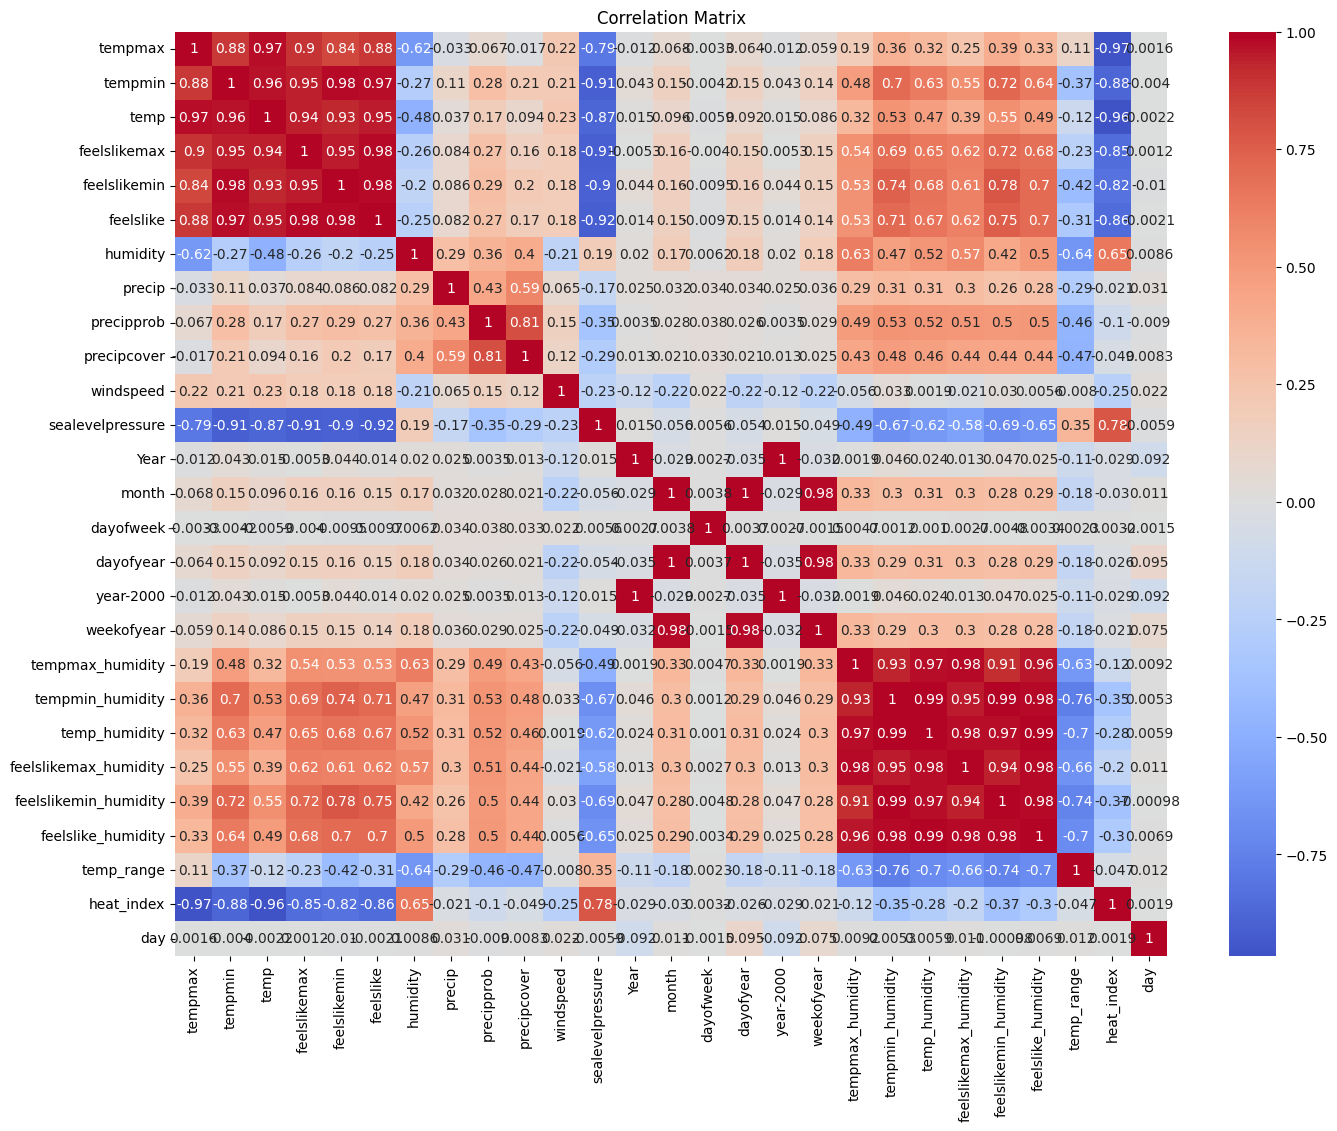

In [106]:
# Check correlation between numerical variables
corr_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [107]:
df.head()

,DATE,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,humidity,precip,precipprob,...,tempmax_humidity,tempmin_humidity,temp_humidity,feelslikemax_humidity,feelslikemin_humidity,feelslike_humidity,temp_range,heat_index,day,day_name
0,2017-01-13,19.0,5.2,11.5,19.0,5.2,11.4,72.7,0.0,0,...,1381.30,378.04,836.05,1381.30,378.04,828.78,13.8,302.327110,13,Friday
1,2017-01-14,18.9,4.4,11.8,18.9,4.4,11.8,75.3,0.0,0,...,1423.17,331.32,888.54,1423.17,331.32,888.54,14.5,302.489293,14,Saturday
2,2017-01-15,23.0,9.0,15.7,23.0,9.0,15.7,66.7,0.0,0,...,1534.10,600.30,1047.19,1534.10,600.30,1047.19,14.0,263.014831,15,Sunday
3,2017-01-16,18.6,9.8,13.8,18.6,7.7,13.6,75.2,0.0,0,...,1398.72,736.96,1037.76,1398.72,579.04,1022.72,8.8,286.145724,16,Monday
4,2017-01-17,15.0,5.0,10.0,15.0,2.1,9.1,87.8,0.0,0,...,1317.00,439.00,878.00,1317.00,184.38,798.98,10.0,323.096619,17,Tuesday


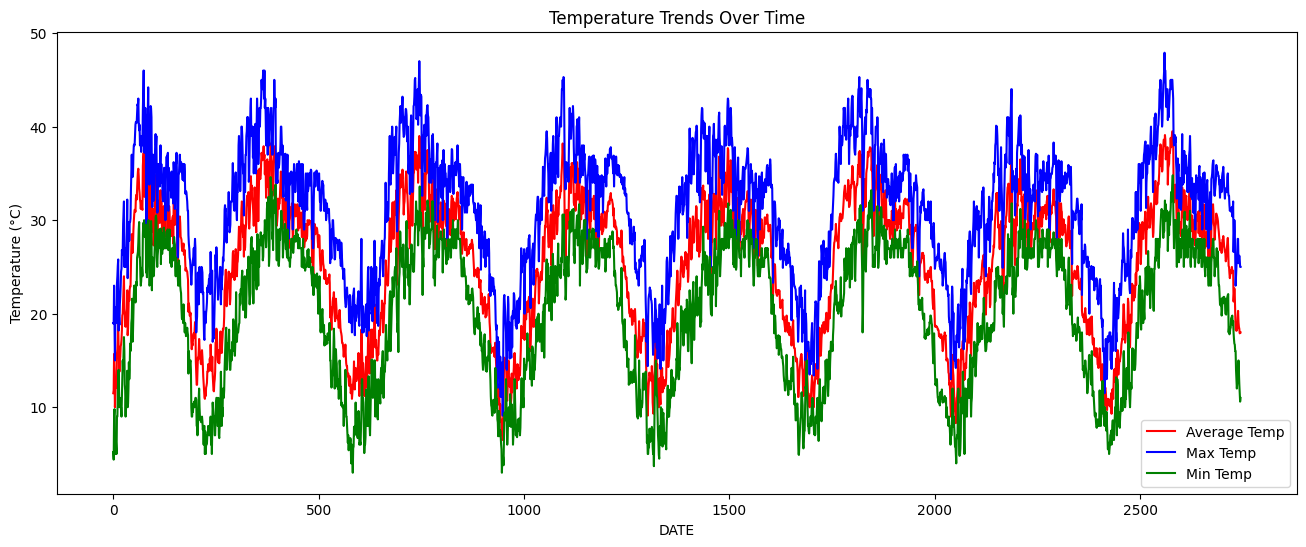

In [113]:
# Plot temperature trends over time
plt.figure(figsize=(16, 6))
plt.plot(df['temp'], label='Average Temp', color='red')
plt.plot(df['tempmax'], label='Max Temp', color='blue')
plt.plot(df['tempmin'], label='Min Temp',color='green')
plt.title('Temperature Trends Over Time')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.legend()
plt.show()

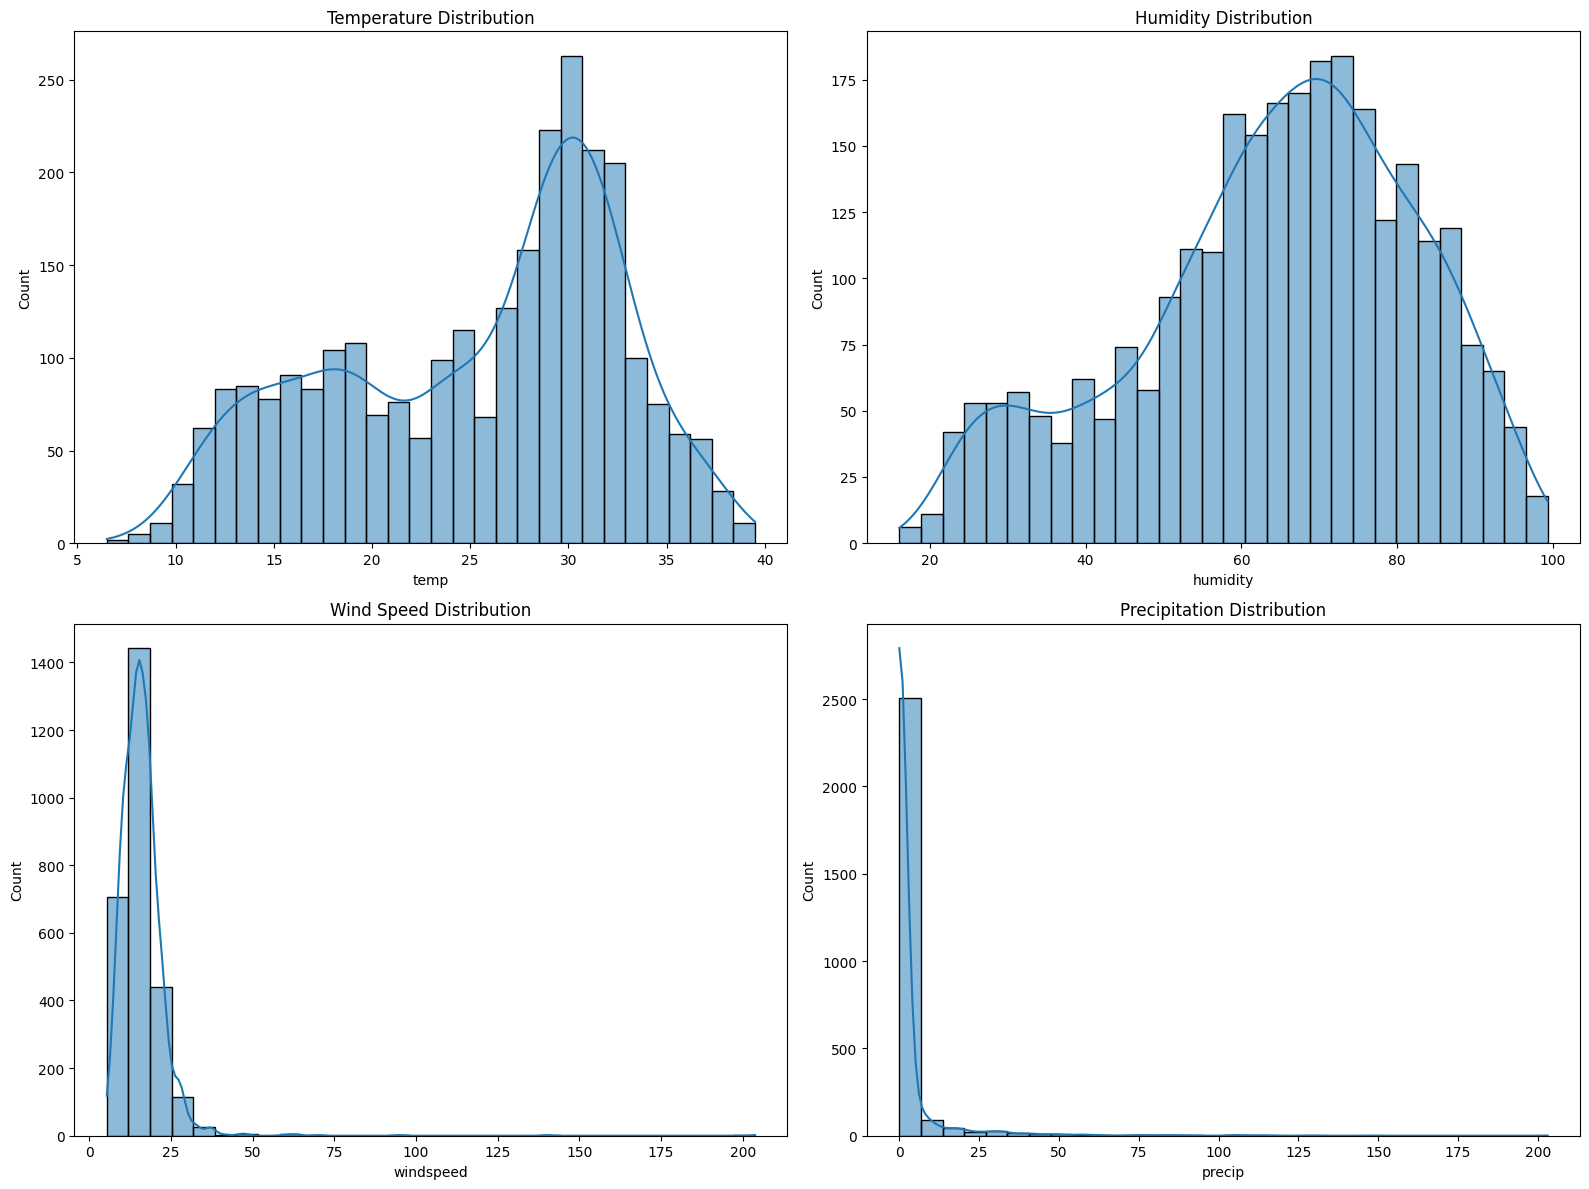

In [69]:
# Plot distributions of key variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(df['temp'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Temperature Distribution')

sns.histplot(df['humidity'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Humidity Distribution')

sns.histplot(df['windspeed'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Wind Speed Distribution')

sns.histplot(df['precip'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Precipitation Distribution')

plt.tight_layout()
plt.show()

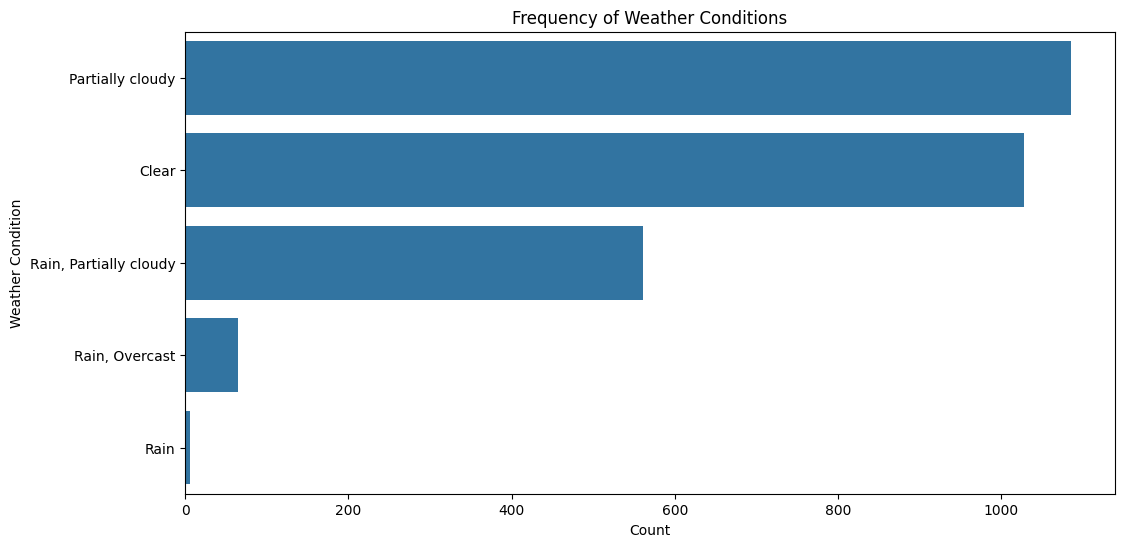

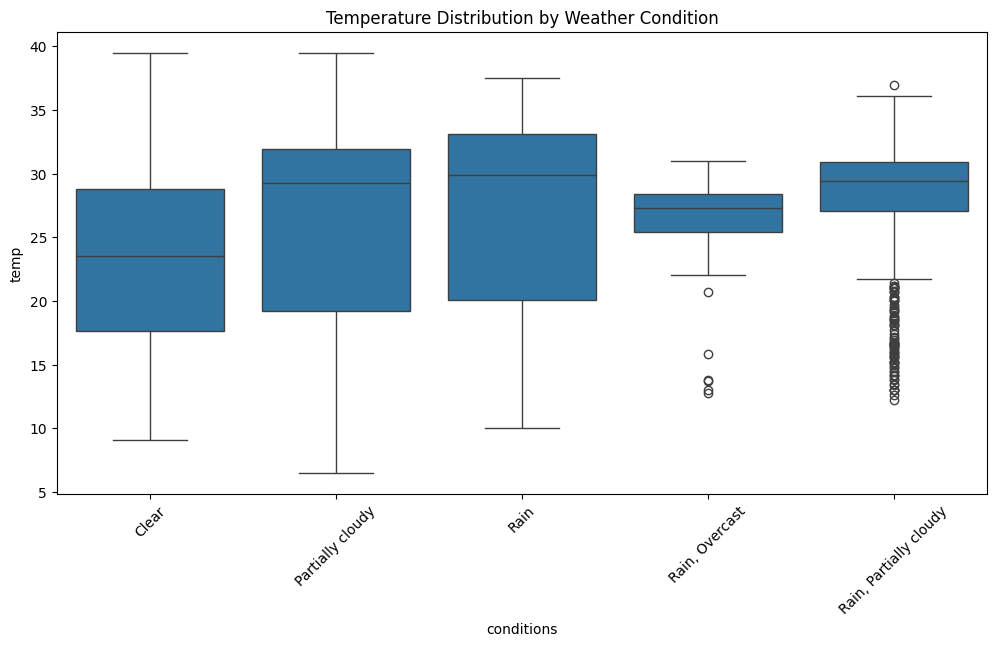

In [70]:
# Analyze weather conditions
plt.figure(figsize=(12, 6))
sns.countplot(y='conditions', data=df, order=df['conditions'].value_counts().index)
plt.title('Frequency of Weather Conditions')
plt.xlabel('Count')
plt.ylabel('Weather Condition')
plt.show()

# Compare temperature by weather condition
plt.figure(figsize=(12, 6))
sns.boxplot(x='conditions', y='temp', data=df)
plt.title('Temperature Distribution by Weather Condition')
plt.xticks(rotation=45)
plt.show()

In [71]:
# Monthly analysis
monthly_stats = df.groupby('month').agg({
    'temp': ['mean', 'min', 'max'],
    'humidity': 'mean',
    'precip': 'sum'
})

print(monthly_stats)

            temp               humidity    precip
            mean   min   max       mean       sum
month                                            
1      12.984322   8.3  19.2  81.504237   431.003
2      17.860280  12.0  24.7  68.862617    87.945
3      23.720339  15.6  31.1  56.660169   255.856
4      30.039912  21.0  35.8  36.167544    82.041
5      32.563291  21.7  39.1  41.369198   436.761
6      33.569298  26.0  39.5  52.550877   801.706
7      31.035593  26.2  37.5  76.622881  2183.388
8      30.278814  26.5  33.1  78.417797  1432.764
9      29.459111  24.0  33.3  76.325333  1137.887
10     26.244068  21.7  30.7  62.230085   281.991
11     20.245614  15.3  25.1  65.394737    23.461
12     14.606341   6.5  19.7  74.878049   149.187


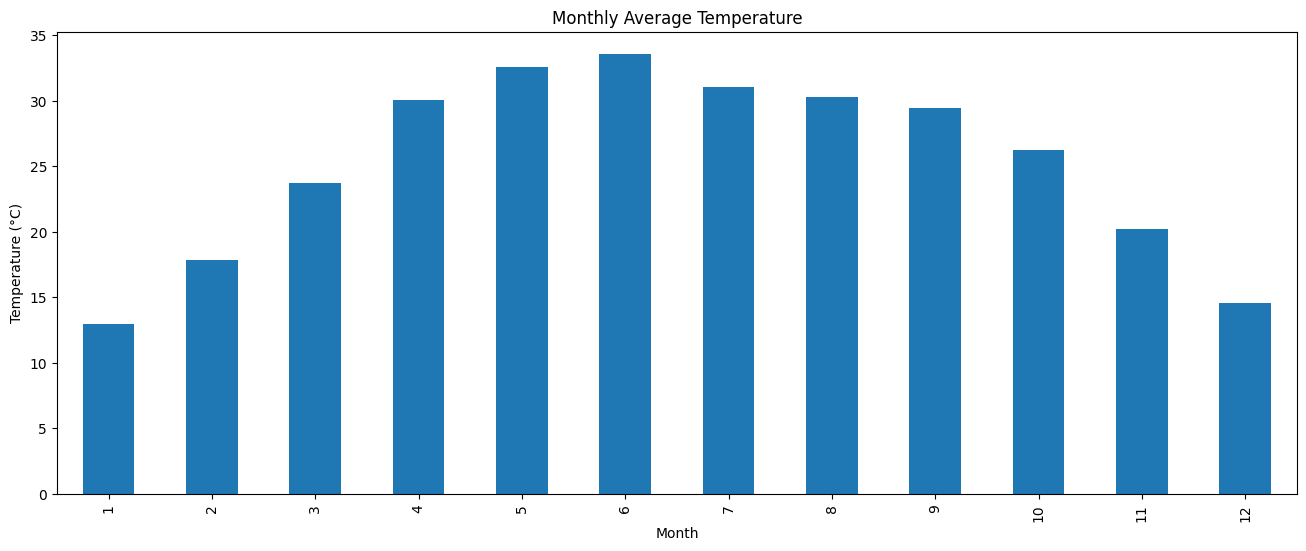

In [72]:
# Plot monthly averages
plt.figure(figsize=(16, 6))
monthly_stats['temp']['mean'].plot(kind='bar')
plt.title('Monthly Average Temperature')
plt.ylabel('Temperature (°C)')
plt.xlabel('Month')
plt.show()

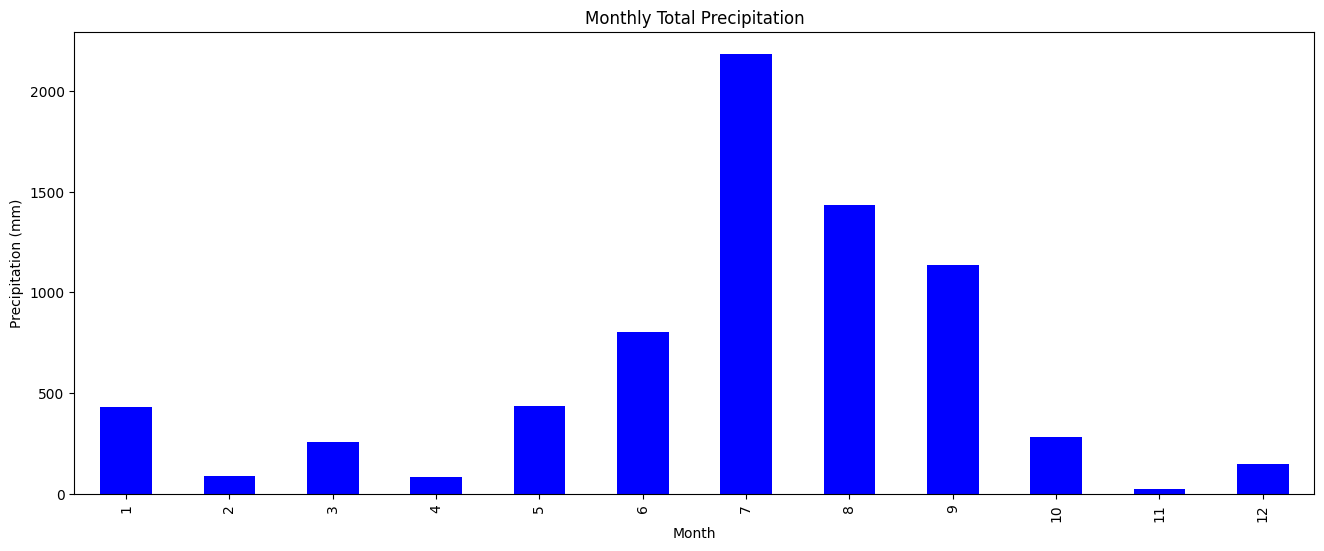

In [73]:
# Seasonal precipitation
plt.figure(figsize=(16, 6))
monthly_stats['precip']['sum'].plot(kind='bar', color='blue')
plt.title('Monthly Total Precipitation')
plt.ylabel('Precipitation (mm)')
plt.xlabel('Month')
plt.show()

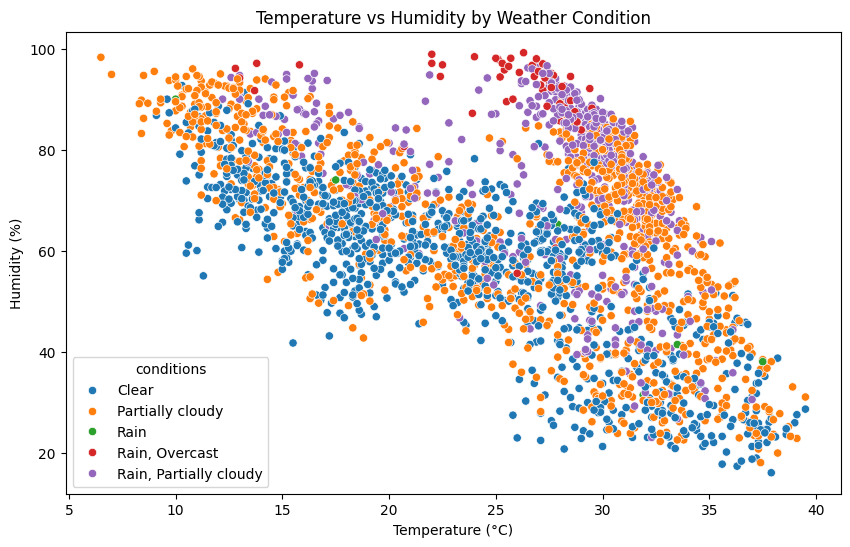

In [74]:
# Scatter plot of temperature vs humidity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='humidity', data=df, hue='conditions')
plt.title('Temperature vs Humidity by Weather Condition')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.show()

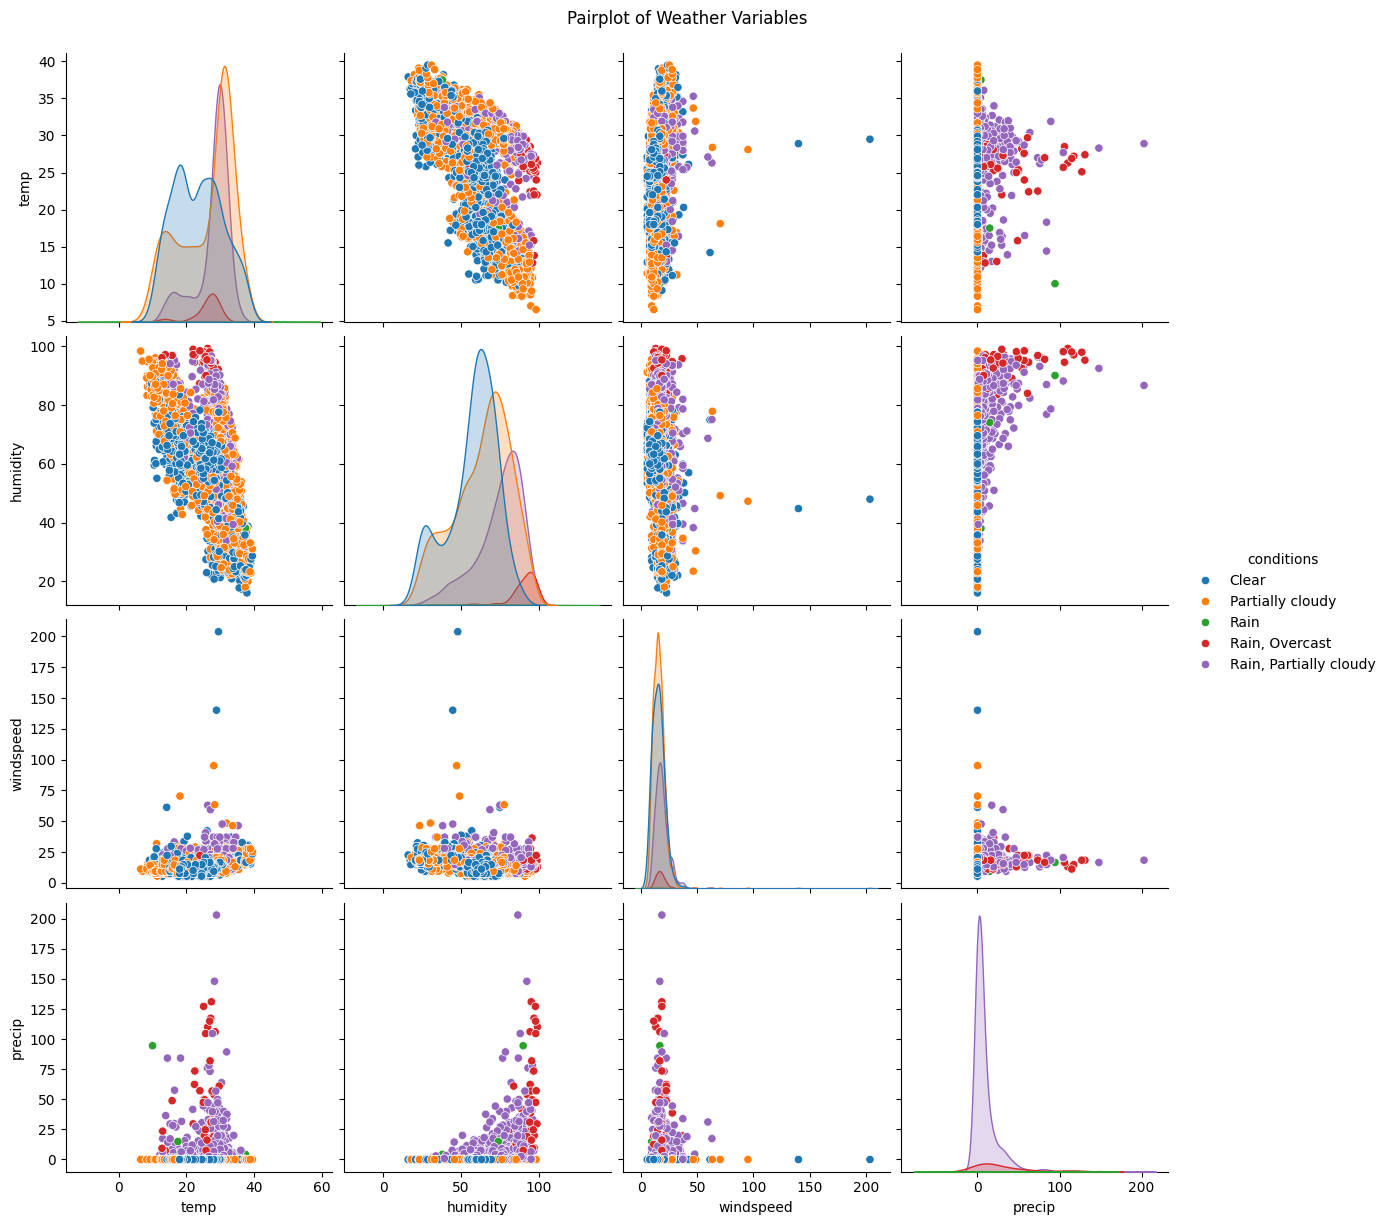

In [75]:
# Pairplot of key variables
sns.pairplot(df[['temp', 'humidity', 'windspeed', 'precip', 'conditions']],
             hue='conditions', height=3)
plt.suptitle('Pairplot of Weather Variables', y=1.02)
plt.show()

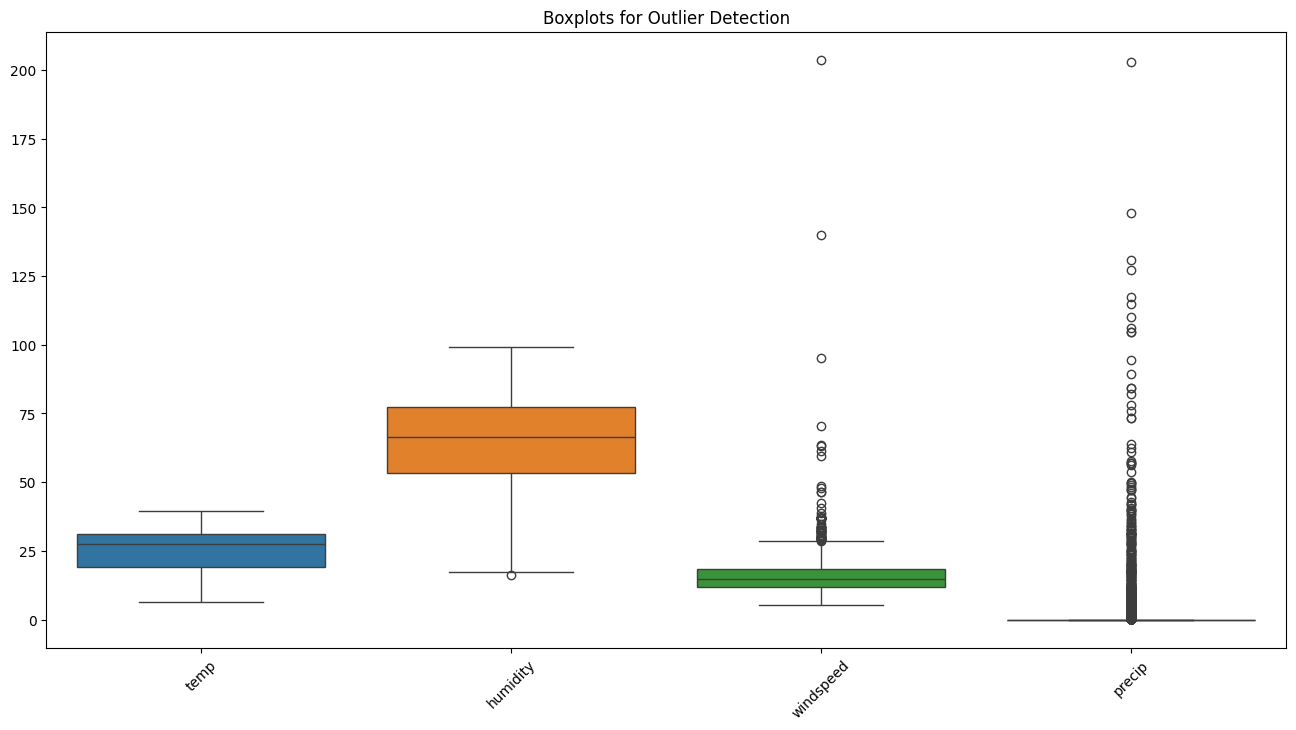

Outliers in temp: 0
Outliers in humidity: 1
Outliers in windspeed: 64
Outliers in precip: 632


In [76]:
# Boxplots for outlier detection
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[['temp', 'humidity', 'windspeed', 'precip']])
plt.title('Boxplots for Outlier Detection')
plt.xticks(rotation=45)
plt.show()

# Function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Check for outliers in key columns
for col in ['temp', 'humidity', 'windspeed', 'precip']:
    outliers = detect_outliers(df, col)
    print(f"Outliers in {col}: {len(outliers)}")